<a href="https://colab.research.google.com/github/jonnythebard/tf2_workbook/blob/master/cipher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# imports

import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [0]:
### create substitution cipher

# one acts as the key, other as the value
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

# shuffle second set of letters
random.shuffle(letters2)

# populate map
for k, v in zip(letters1, letters2):
  true_mapping[k] = v

In [0]:
### the language model

# initiate Markov matrix
M = np.ones((26, 26))

# initiate state distribution
pi = np.zeros(26)

# a function to update the Markov matrix
def update_markov_matrix(ch1, ch2):
  i = ord(ch1) - 97
  j = ord(ch2) - 97
  M[i, j] += 1

# a function to update the initial state distribution
def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1

# get the log-probability of a token
def get_word_prob(word):
  i = ord(word[0]) - 97
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i, j])
    i = j

  return logp

# get the probability of a sequence of words
def get_sequence_prob(words):
  # if input is a string, split into an array of tokens
  if type(words) == str:
    words = words.split()
  
  logp = 0
  for word in words:
    logp += get_word_prob(word)
  
  return logp

In [0]:
### create a markov model based on an English dataset
# is an edit of https://www.gutenberg.org/ebooks/2701
# (I removed the front and back matter)

# download the file
if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w') as f:
    f.write(r.content.decode())

In [0]:
### build the language model

# for replacing non-alphabet characters
regex = re.compile("[^a-zA-Z]")

# load in the words
for line in open("moby_dick.txt"):
  line = line.rstrip()

  # there are blank lines in the file
  if line:
    line = regex.sub(" ", line)

    # split the tokens in the line and lowercase
    tokens = line.lower().split()

    for token in tokens:
      ## update the model

      # first letters
      ch0 = token[0]
      update_pi(ch0)

      # other letters
      for ch1 in token[1:]:
        update_markov_matrix(ch0, ch1)
        ch0 = ch1
    
# normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [0]:
# encode the message

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

def encode_message(msg):
  msg = msg.lower()

  # replace non-alphabet chars
  msg = regex.sub(" ", msg)

  # make the encoded message
  coded_msg = []
  for ch in msg:
    coded_ch = ch # colud be just a space
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)

  return "".join(coded_msg)

def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)
  
  return "".join(decoded_msg)

encoded_message = encode_message(original_message)

In [7]:
### run an evolutionary algorithm to decode the message

# initailize dna
dna_pool = []
for _ in range(200):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

def evolve_offspring(dna_pool, n_children):
  # make n_children per an offspring
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()

      t = np.random.randint(len(copy))
      r = np.random.randint(len(copy))

      # evolve
      copy[t], copy[r] = copy[r], copy[t]
      offspring.append(copy)

  return offspring + dna_pool

generations = 100
scores = np.zeros(generations)
best_dna = None
best_map = None
best_score = float("-inf")

for i in range(generations):
  if i > 0:
    dna_pool = evolve_offspring(dna_pool, 30)

  # calculate score for each dna
  dna2score = {}
  for dna in dna_pool:
    current_map = dict(zip(letters1, dna))
    
    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    dna2score["".join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

    scores[i] = np.mean(list(dna2score.values()))

    # keep best 50 dna
    sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
    dna_pool = [list(k) for k, v in sorted_dna[:50]]

  if i % 10 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -2100.183616428767 best so far: -1666.8453428957537
iter: 10 score: -1281.570725931025 best so far: -1169.7836614689056
iter: 20 score: -1137.6868617830808 best so far: -1000.6011849869421
iter: 30 score: -1067.2123498481494 best so far: -929.5902922650557
iter: 40 score: -1062.6662477076666 best so far: -929.5902922650557
iter: 50 score: -1057.1838190530339 best so far: -929.5902922650557
iter: 60 score: -1059.603825148603 best so far: -929.5902922650557
iter: 70 score: -1053.6251729419769 best so far: -929.5902922650557
iter: 80 score: -1058.4917986488115 best so far: -929.5902922650557
iter: 90 score: -1058.7409445004512 best so far: -929.5902922650557


In [8]:
# use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.5902922650557
LL of true message: -933.0312453751817
true: j, pred: z
true: k, pred: q
true: q, pred: j
true: z, pred: k


In [9]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

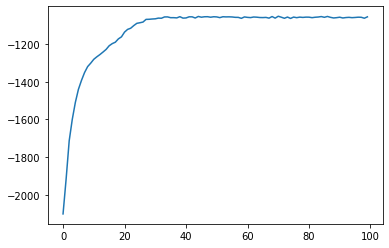

In [10]:
plt.plot(scores)
plt.show()